In [1]:
import matplotlib.pyplot as plot
import numpy
import pandas
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

import seaborn
seaborn.set_context('talk')

import statistics
import collections
from collections import Counter
from scipy import stats
import re

In [2]:
def describe(data,column):
    x = data[column]
    c = x.count()
    s = x.unique().size
    m = statistics.mode(x)
    t = Counter(x)[m]
    n = x.isna().sum()
    e = numpy.where(x.map(lambda v: v == ''))[0].size # empty values
    z = numpy.where(x.map(lambda v: v == 0))[0].size # empty values
    print(f'Hay {c} elementos.')
    print(f'Hay {s} elementos únicos.')
    print(f'El elemento mas frecuente es {m} y ocurre {t} veces.')
    print(f"Hay {n} elementos nulos.")
    print(f"Hay {e} elementos vacíos.")
    print(f"Hay {z} elementos con ceros.")

In [3]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

In [4]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'4.14.3'

In [5]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

In [6]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [7]:
# data source:
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv'
url = 'cleansed_listings_dec18.csv'
airbnb_df = pandas.read_csv(url,usecols=interesting_cols,low_memory=False)

In [8]:
airbnb_df[:3]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0


In [9]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

In [10]:
melb_df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [11]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

# Ejercicio 1

## MELB_DF

### Feature Suburb

Hay 13580 elementos.
Hay 314 elementos únicos.
El elemento mas frecuente es Reservoir y ocurre 359 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Suburb', ylabel='Count'>

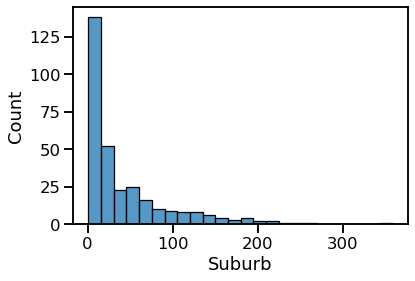

In [12]:
describe(melb_df,'Suburb')
vc = melb_df.Suburb.value_counts()
seaborn.histplot(vc)

In [13]:
melb_df.Suburb.value_counts(normalize=True).to_frame() # Frecuencia relativa de cada valor único

,Suburb
Reservoir,0.026436
Richmond,0.019146
Bentleigh East,0.018336
Preston,0.017599
Brunswick,0.016348
...,...
Bacchus Marsh,0.000074
Bullengarook,0.000074
Sandhurst,0.000074
Wallan,0.000074


In [14]:
melb_df.Suburb.value_counts().to_frame()

,Suburb
Reservoir,359
Richmond,260
Bentleigh East,249
Preston,239
Brunswick,222
...,...
Bacchus Marsh,1
Bullengarook,1
Sandhurst,1
Wallan,1


In [15]:
print(re.search("^[{o}{O}]ther^s$","Other"))

None


In [16]:
def searchOther(txt):
    search = re.search("^[{o}{O}]ther", txt) or re.search("^[{o}{O}]thers", txt)
    if (search == None):
        return False
    return True

In [17]:
melb_df[melb_df.Suburb == 'others']

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount


In [18]:
melb_df.Suburb.value_counts().describe()

count    314.000000
mean      43.248408
std       55.138994
min        1.000000
25%        6.250000
50%       20.500000
75%       59.000000
max      359.000000
Name: Suburb, dtype: float64

In [19]:
melb_df.Suburb.value_counts()

Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Bacchus Marsh       1
Bullengarook        1
Sandhurst           1
Wallan              1
Healesville         1
Name: Suburb, Length: 314, dtype: int64

### Feature Address

In [20]:
describe(melb_df,'Address')

Hay 13580 elementos.
Hay 13378 elementos únicos.
El elemento mas frecuente es 5 Charles St y ocurre 3 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature Type

Hay 13580 elementos.
Hay 3 elementos únicos.
El elemento mas frecuente es h y ocurre 9449 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Type', ylabel='Count'>

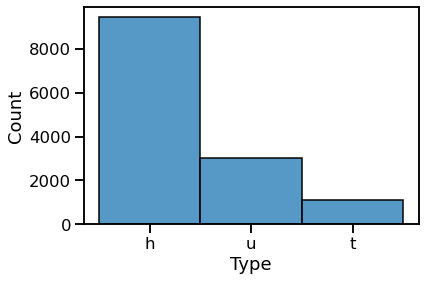

In [21]:
describe(melb_df,'Type')
seaborn.histplot(data=melb_df, x='Type')

### Feature Price

Hay 13580 elementos.
Hay 2204 elementos únicos.
El elemento mas frecuente es 1100000.0 y ocurre 113 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Price'>

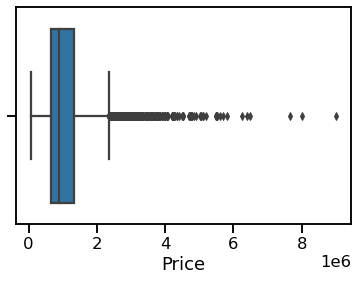

In [22]:
describe(melb_df,'Price')
seaborn.boxplot(data=melb_df, x='Price')

Feature elegida para remover outliers, al ser una variable numérica continua

Después de remover outlier con IQR mantenemos un porcentaje del 95.41 % sobre el dataset original
Hay 12956 elementos.
Hay 1945 elementos únicos.
El elemento mas frecuente es 1100000.0 y ocurre 113 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Price'>

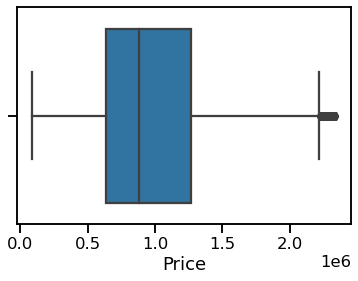

In [23]:
iqr_factor = 1.5
price = melb_df.copy()
price_main_inliers, price_main_outliers = remove_outlier(price, "Price", iqr_factor)
p = (len(price_main_inliers) / len(price)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(price_main_inliers,'Price')
seaborn.boxplot(data=price_main_inliers, x='Price')

In [24]:
melb_df = price.copy()

### Feature Method

Hay 13580 elementos.
Hay 5 elementos únicos.
El elemento mas frecuente es S y ocurre 9022 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Method', ylabel='Count'>

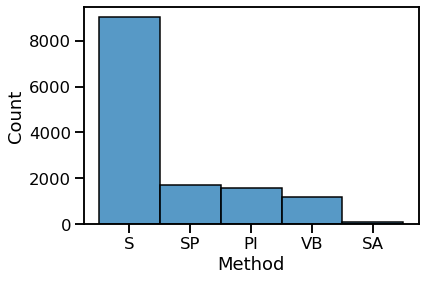

In [25]:
describe(melb_df,'Method')
seaborn.histplot(data=melb_df, x='Method')

### Feature SellerG

In [26]:
describe(melb_df,'SellerG')

Hay 13580 elementos.
Hay 268 elementos únicos.
El elemento mas frecuente es Nelson y ocurre 1565 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


El nombre del vendedor no aporta información para la predicción

### Feature Date

In [27]:
describe(melb_df,'Date')

Hay 13580 elementos.
Hay 58 elementos únicos.
El elemento mas frecuente es 27/05/2017 y ocurre 473 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


La fecha de venta no aporta información para la predicción

### Feature Distance

Hay 13580 elementos.
Hay 202 elementos únicos.
El elemento mas frecuente es 11.2 y ocurre 739 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 6 elementos con ceros.


<AxesSubplot:xlabel='Distance'>

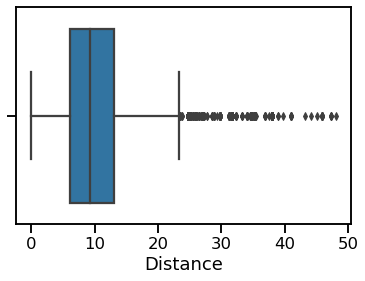

In [28]:
describe(melb_df,'Distance')
seaborn.boxplot(data=melb_df,x='Distance')

Podríamos separar en categorías, centro < 10, cercano a centro < 25 y lejos del centro el resto.

Se propone la categoría 1: centro 2: cercano 3: lejos

Los ceros no perjudican.

In [29]:
distance = melb_df.copy()
quantile_25 = numpy.quantile(distance.Distance,0.25)
quantile_50 = numpy.quantile(distance.Distance,0.50)
print("Quantiles a utilizar para categorizar")
print(f"quantile 25 {quantile_25}")
print(f"quantile 50 {quantile_50}\n")

distance.loc[distance.Distance <= quantile_25, 'Distance'] = int(1)
distance.loc[(distance.Distance >= quantile_25) & (distance.Distance < quantile_50), 'Distance'] = int(2)
distance.loc[distance.Distance >= quantile_50, 'Distance'] = int(3)

describe(distance,'Distance')
print("\nCantidad de elementos de cada nueva categoría")
print(distance.Distance.value_counts())

Quantiles a utilizar para categorizar
quantile 25 6.1
quantile 50 9.2

Hay 13580 elementos.
Hay 3 elementos únicos.
El elemento mas frecuente es 3.0 y ocurre 7109 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.

Cantidad de elementos de cada nueva categoría
3.0    7109
1.0    3397
2.0    3074
Name: Distance, dtype: int64


In [30]:
melb_df = distance.copy()

### Feature Postcode

In [31]:
describe(melb_df,'Postcode')

Hay 13580 elementos.
Hay 198 elementos únicos.
El elemento mas frecuente es 3073.0 y ocurre 359 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature Rooms

Hay 13580 elementos.
Hay 9 elementos únicos.
El elemento mas frecuente es 3 y ocurre 5881 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Rooms'>

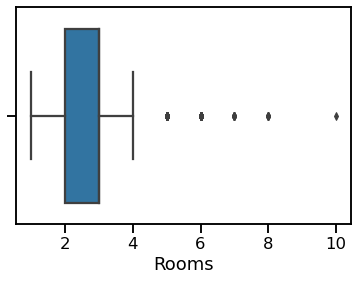

In [32]:
describe(melb_df,'Rooms')
seaborn.boxplot(data=melb_df, x='Rooms')

El feature no cuenta con elementos nulos, ni vacíos ni con cero. Esta feature es candidata a ser agrupada. Se elige la condición de mayores a 4

Hay 13580 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 3 y ocurre 5881 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Rooms'>

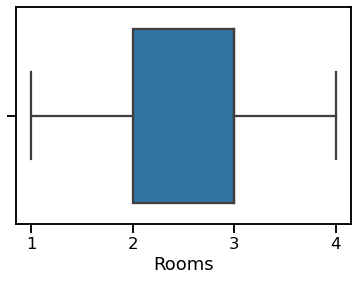

In [33]:
rooms1 = melb_df.copy()
rooms1.loc[rooms1.Rooms > 4, 'Rooms'] = 4 # o 5
describe(rooms1,'Rooms')
seaborn.boxplot(data=rooms1,x='Rooms')

Después de remover outlier con IQR mantenemos un porcentaje del 94.98 % sobre el dataset original
Hay 12898 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 3 y ocurre 5881 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Rooms'>

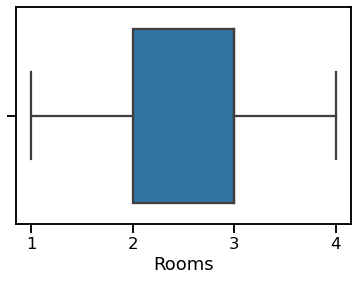

In [34]:
iqr_factor = 1.5
rooms2 = melb_df.copy()
rooms_main_inliers, rooms_main_outliers = remove_outlier(rooms2, "Rooms", iqr_factor)
p = (len(rooms_main_inliers) / len(rooms2)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(rooms_main_inliers,'Rooms')
seaborn.boxplot(data=rooms_main_inliers, x='Rooms')

In [35]:
melb_df = rooms_main_inliers.copy()

### Feature Bedroom2

Hay 12898 elementos.
Hay 8 elementos únicos.
El elemento mas frecuente es 3.0 y ocurre 5877 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 16 elementos con ceros.


<AxesSubplot:xlabel='Bedroom2'>

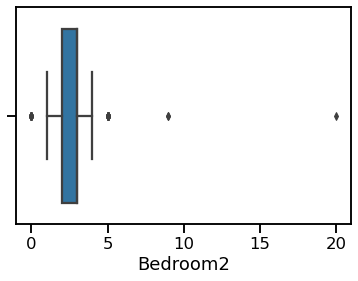

In [36]:
describe(melb_df,'Bedroom2')
seaborn.boxplot(data=melb_df,x='Bedroom2')

Elementos con ceros asignarle 1, pueden ser de otra categoría (quincho, garage, galpón, etc), como trabajamos con datos que especifican que son de ventas de propiedades damos por supuesto que todas las casas deben tener por lo menos un dormitorio.

También es un candidato a remover outliers. La propiedad con 20 habitaciones puede ser una mansión o un complejo,etc

Hay 12898 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 3.0 y ocurre 5877 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Bedroom2'>

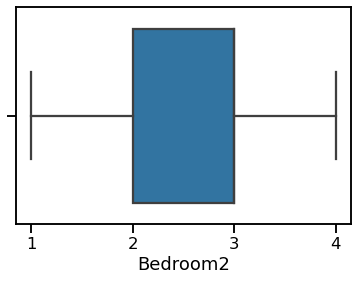

In [37]:
bedroom1 = melb_df.copy()
bedroom1.loc[bedroom1.Bedroom2 == 0, 'Bedroom2'] = 1
bedroom1.loc[bedroom1.Bedroom2 > 4, 'Bedroom2'] = 4 # o 5
describe(bedroom1,'Bedroom2')
seaborn.boxplot(data=bedroom1,x='Bedroom2')

Después de remover outlier con IQR mantenemos un porcentaje del 99.69 % sobre el dataset original
Hay 12858 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 3.0 y ocurre 5877 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Bedroom2'>

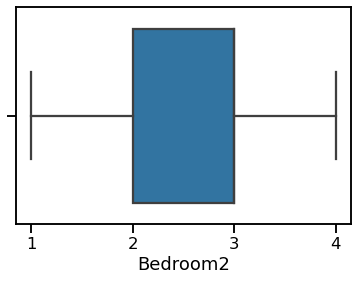

In [38]:
iqr_factor = 1.5
bedroom2 = melb_df.copy()
bedroom_main_inliers, bedroom_main_outliers = remove_outlier(bedroom2, "Bedroom2", iqr_factor)
p = (len(bedroom_main_inliers) / len(bedroom2)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(bedroom_main_inliers,'Bedroom2')
seaborn.boxplot(data=bedroom_main_inliers, x='Bedroom2')

In [39]:
melb_df = bedroom_main_inliers.copy()

### Análisis variable Bedroom2 y Room

In [40]:
Bedroom2 = melb_df.Bedroom2
Rooms = melb_df.Rooms
pandas.crosstab(Bedroom2,Rooms)

Rooms,1,2,3,4
Bedroom2,,,,
1.0,663,21,5,2
2.0,16,3539,162,19
3.0,2,74,5626,175
4.0,0,8,73,2473


La variable Rooms es mucho mas informativa que la variable Bedroom2. Por esto decidimos sacar la variable Bedroom2

In [41]:
melb_df.drop(['Bedroom2'], axis=1, inplace=True)

### Feature Bathroom

Hay 12858 elementos.
Hay 6 elementos únicos.
El elemento mas frecuente es 1.0 y ocurre 7484 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 28 elementos con ceros.


<AxesSubplot:xlabel='Bathroom'>

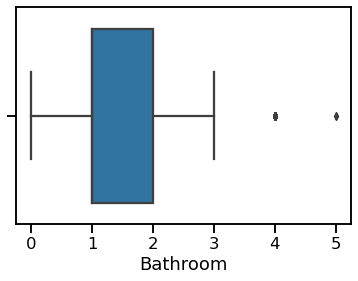

In [42]:
describe(melb_df,'Bathroom')
seaborn.boxplot(data=melb_df,x='Bathroom')

La misma suposición realizada respecto de Bedroom2, damos por supuesto que trabajamos con propiedades tipo casas y aquellas con valores ceros le asignaremos un 1.

Se propone unificar todas aquellas filas con mayor a 3 con valor 4

Hay 12858 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 1.0 y ocurre 7512 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Bathroom'>

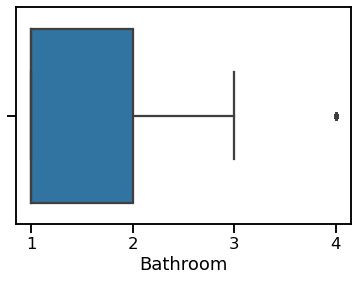

In [43]:
bathroom = melb_df.copy()
bathroom.loc[bathroom.Bathroom == 0, 'Bathroom'] = 1
#bathroom.loc[bathroom.Bathroom > numpy.quantile(bathroom.Bathroom,0.75), 'Bathroom'] = "+075"
bathroom.loc[bathroom.Bathroom > 3, 'Bathroom'] = 4
describe(bathroom,'Bathroom')
seaborn.boxplot(data=bathroom,x='Bathroom')

Después de remover outlier con IQR mantenemos un porcentaje del 94.32 % sobre el dataset original
Hay 12809 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 1.0 y ocurre 7484 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 28 elementos con ceros.


<AxesSubplot:xlabel='Bathroom'>

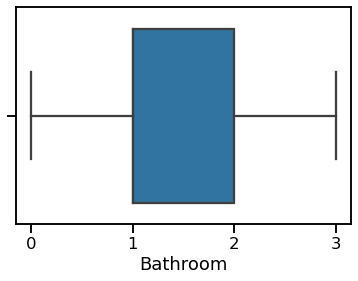

In [44]:
iqr_factor = 1.5
bathroom = melb_df.copy()
bathroom_main_inliers, bathroom_main_outliers = remove_outlier(bathroom, "Bathroom", iqr_factor)
p = (len(bathroom_main_inliers) / len(price)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(bathroom_main_inliers,'Bathroom')
seaborn.boxplot(data=bathroom_main_inliers, x='Bathroom')

Al remover outlier comprobamos que obtenemos mejores resultados

In [45]:
melb_df = bathroom.copy()

### Feature Car

Hay 12796 elementos.
Hay 12 elementos únicos.
El elemento mas frecuente es 1.0 y ocurre 5449 veces.
Hay 62 elementos nulos.
Hay 0 elementos vacíos.
Hay 1004 elementos con ceros.


<AxesSubplot:xlabel='Car'>

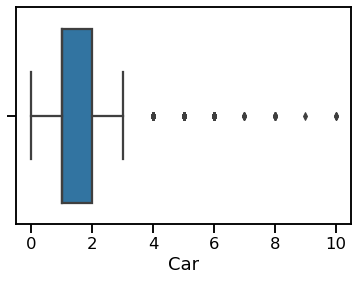

In [46]:
describe(melb_df,'Car')
seaborn.boxplot(data=melb_df,x='Car')

Pueden existir casas sin cocheras. Hay 1026 casas sin cocheras. 62 con datos nulos, se reemplazan con cero

Hay 12858 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 1.0 y ocurre 5449 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 1066 elementos con ceros.


<AxesSubplot:xlabel='Car'>

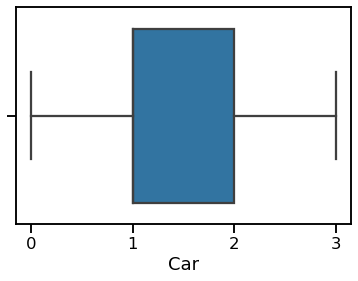

In [47]:
car1 = melb_df.copy()
car1.loc[car1.Car > 3, 'Car'] = 3
car1.fillna({'Car':0}, inplace=True)
describe(car1,'Car')
seaborn.boxplot(data=car1,x='Car')

Después de remover outlier con IQR mantenemos un porcentaje del 95.36 % sobre el dataset original
Hay 12262 elementos.
Hay 4 elementos únicos.
El elemento mas frecuente es 1.0 y ocurre 5449 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 1004 elementos con ceros.


<AxesSubplot:xlabel='Car'>

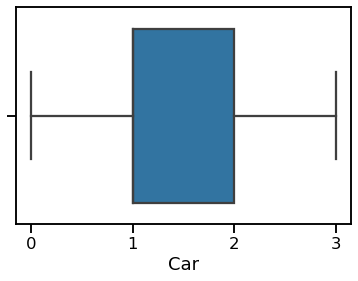

In [48]:
iqr_factor = 1.5
car2 = melb_df.copy()
car_main_inliers, car_main_outliers = remove_outlier(car2, "Car", iqr_factor)
p = (len(car_main_inliers) / len(car2)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(car_main_inliers,'Car')
seaborn.boxplot(data=car_main_inliers, x='Car')

Se obtienen mejores resultados al aplicar remoción de outliers

In [49]:
melb_df = car1.copy()

### Feature Landsize

Hay 12858 elementos.
Hay 1413 elementos únicos.
El elemento mas frecuente es 0.0 y ocurre 1928 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 1928 elementos con ceros.


<AxesSubplot:xlabel='Landsize'>

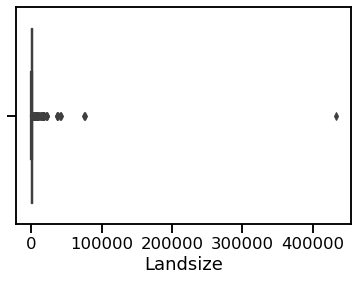

In [50]:
describe(melb_df,'Landsize')
seaborn.boxplot(data=melb_df,x='Landsize')

La variable tienen muchos datos faltantes y no aportan informacion al análisis.

Hay 7211 elementos.
Hay 525 elementos únicos.
El elemento mas frecuente es 585.0 y ocurre 46 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Landsize'>

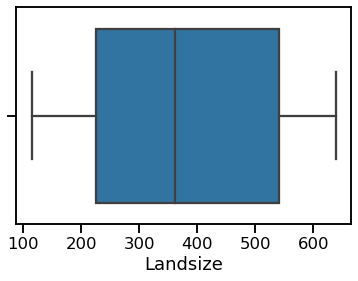

In [51]:
# Como concepto se realiza filtrado por valores menores al quatile .75 y mayores al quantile .25
landsize1 = melb_df.copy()
landsize1 = landsize1[landsize1['Landsize'] < numpy.quantile(landsize1['Landsize'], 0.75)]
landsize1 = landsize1[landsize1['Landsize'] > numpy.quantile(landsize1['Landsize'], 0.25)]
describe(landsize1,'Landsize')
seaborn.boxplot(data=landsize1,x='Landsize')

Después de remover outlier con IQR mantenemos un porcentaje del 95.98 % sobre el dataset original
Hay 9242 elementos.
Hay 952 elementos únicos.
El elemento mas frecuente es 650.0 y ocurre 94 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='Landsize'>

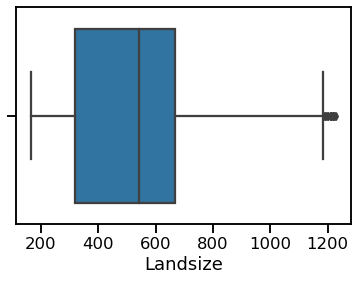

In [52]:
iqr_factor = 1.5
landsize2 = melb_df.copy()
landsize2 = landsize2[landsize2['Landsize'] > numpy.quantile(landsize2['Landsize'], 0.25)]
landsize_main_inliers, landsize_main_outliers = remove_outlier(landsize2, "Landsize", iqr_factor)
p = (len(landsize_main_inliers) / len(landsize2)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(landsize_main_inliers,'Landsize')
seaborn.boxplot(data=landsize_main_inliers, x='Landsize')

In [53]:
melb_df = landsize_main_inliers.copy()

### Feature BuildingArea

Hay 4738 elementos.
Hay 496 elementos únicos.
El elemento mas frecuente es 120.0 y ocurre 100 veces.
Hay 4504 elementos nulos.
Hay 0 elementos vacíos.
Hay 11 elementos con ceros.


<AxesSubplot:xlabel='BuildingArea'>

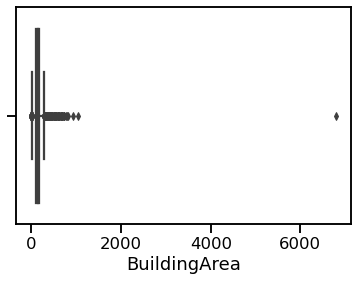

In [54]:
describe(melb_df,'BuildingArea')
seaborn.boxplot(data=melb_df,x='BuildingArea')

Hay 4727 elementos.
Hay 485 elementos únicos.
El elemento mas frecuente es 120.0 y ocurre 100 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 11 elementos con ceros.


<AxesSubplot:xlabel='BuildingArea'>

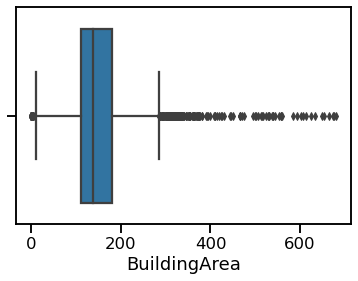

In [55]:
buildingArea = melb_df.copy()
buildingArea = buildingArea[buildingArea.BuildingArea < 700]
describe(buildingArea,'BuildingArea')
seaborn.boxplot(data=buildingArea,x='BuildingArea')

La variable tienen datos faltantes, datos con ceros y no aportan informacion al análisis.

### Feature YearBuilt

Hay 5360 elementos.
Hay 136 elementos únicos.
El elemento mas frecuente es 1960.0 y ocurre 506 veces.
Hay 3882 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='YearBuilt'>

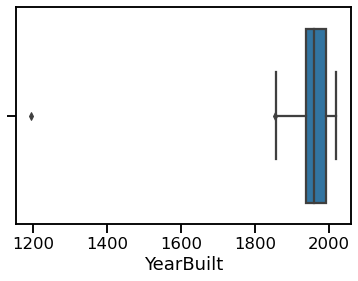

In [56]:
describe(melb_df,'YearBuilt')
seaborn.boxplot(data=melb_df,x='YearBuilt')

Hay 5360 elementos.
Hay 115 elementos únicos.
El elemento mas frecuente es 1960.0 y ocurre 506 veces.
Hay 3882 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='YearBuilt'>

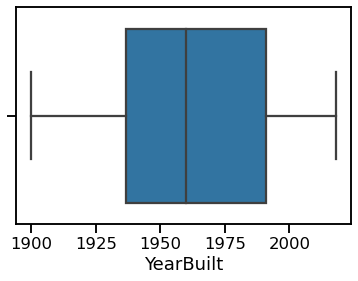

In [57]:
yearBuilt = melb_df.copy()
yearBuilt.loc[yearBuilt.YearBuilt < 1900, 'YearBuilt'] = 1900
describe(yearBuilt,'YearBuilt')
seaborn.boxplot(data=yearBuilt,x='YearBuilt')

La variable tienen muchos datos faltantes y no aportan informacion al análisis.

### Feature CouncilArea

In [58]:
describe(melb_df,'CouncilArea')

Hay 8093 elementos.
Hay 34 elementos únicos.
El elemento mas frecuente es nan y ocurre 1149 veces.
Hay 1149 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


Completo los valores nan de CouncilArea con los valores de Postcode

In [59]:
def searchCouncilArea(df,postCode):
    result = df[df.Postcode == postCode]
    return result.iloc[0].CouncilArea

In [60]:
councilArea = melb_df.copy()
for index, row in melb_df.iterrows():
    searched = searchCouncilArea(melb_df,row["Postcode"])
    councilArea.loc[index,'CouncilArea'] = searched

In [61]:
melb_df = councilArea.copy()

In [62]:
describe(melb_df,'CouncilArea')

Hay 9239 elementos.
Hay 33 elementos únicos.
El elemento mas frecuente es Moreland y ocurre 940 veces.
Hay 3 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


La cantidad de valores nan disminuyó considreablemnte. Se eliminan los valores nulos restantes que no tienen coincidencia de Postcode

In [63]:
melb_df[melb_df['CouncilArea'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12531,Hurstbridge,3 Milton Wy,3,h,600000.0,S,Mason,9/09/2017,3.0,3099.0,2.0,0.0,785.0,NaN,NaN,NaN,-37.63700,145.20166,Northern Victoria,1345.0
12865,Wallan,14 Danaher Av,3,h,366000.0,S,Ray,16/09/2017,3.0,3756.0,1.0,1.0,502.0,77.0,1978.0,NaN,-37.40853,144.97749,Northern Victoria,3988.0
13030,Mount Evelyn,4 Longview Rd,3,h,515000.0,S,Ray,19/08/2017,3.0,3796.0,1.0,0.0,915.0,101.0,1970.0,NaN,-37.78495,145.39190,Eastern Victoria,3532.0


### Feature Latitude

In [64]:
describe(melb_df,'Lattitude')

Hay 9242 elementos.
Hay 5389 elementos únicos.
El elemento mas frecuente es -37.7609 y ocurre 11 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature Longitude

In [65]:
describe(melb_df,'Longtitude')

Hay 9242 elementos.
Hay 5836 elementos únicos.
El elemento mas frecuente es 145.0243 y ocurre 9 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature Region Name

Hay 9242 elementos.
Hay 8 elementos únicos.
El elemento mas frecuente es Southern Metropolitan y ocurre 2775 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


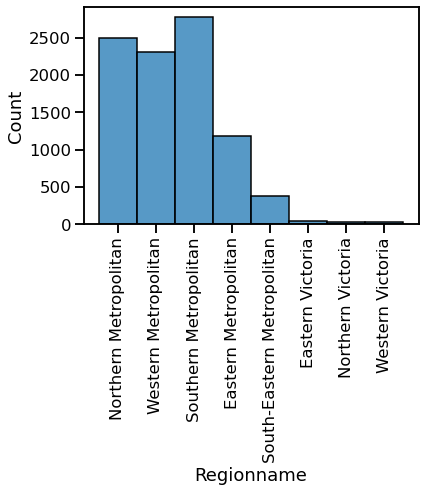

In [66]:
describe(melb_df,'Regionname')
seaborn.histplot(data=melb_df,x='Regionname')
plot.xticks(rotation=90)
plot.show()

### Feature Propertycount

In [67]:
describe(melb_df,'Propertycount')

Hay 9242 elementos.
Hay 303 elementos únicos.
El elemento mas frecuente es 21650.0 y ocurre 262 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Análisis valores faltantes

<AxesSubplot:>

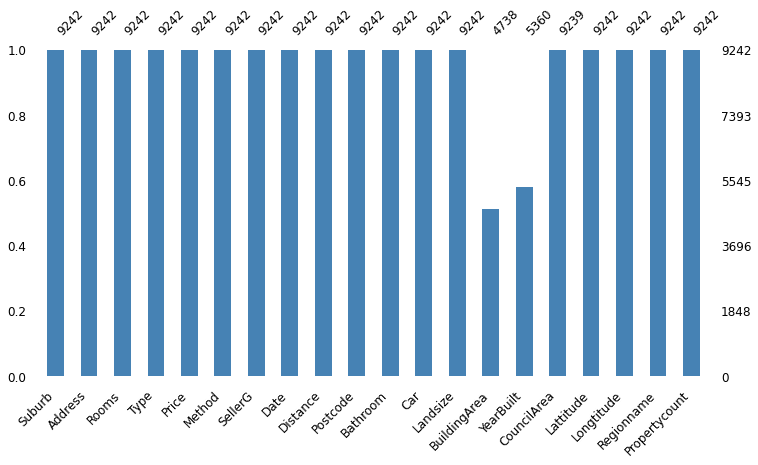

In [68]:
msno.bar(melb_df,figsize=(12, 6), fontsize=12, color='steelblue')

<AxesSubplot:>

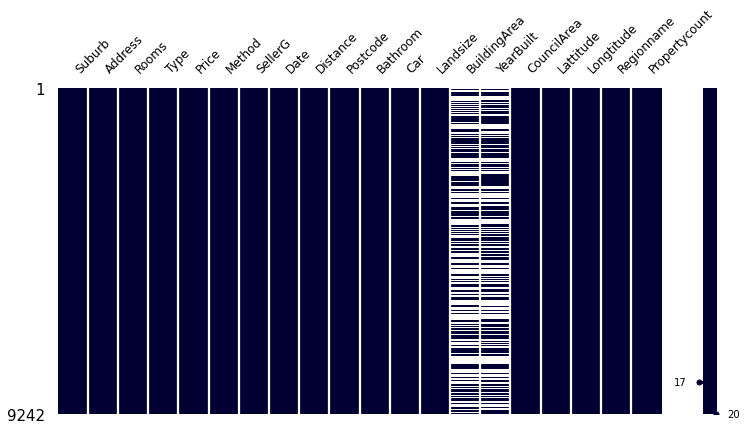

In [69]:
msno.matrix(melb_df,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

In [70]:
melb_df.describe().round(2)

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,9242.00,9242.00,9242.00,9242.00,9242.00,9242.00,9242.00,4738.00,5360.00,9242.00,9242.00,9242.00
mean,3.09,1141443.37,2.46,3104.04,1.54,1.67,518.47,155.65,1960.81,-37.81,145.00,7279.17
std,0.69,599845.56,0.75,96.91,0.63,0.78,218.65,123.42,37.03,0.09,0.11,4382.74
min,1.00,131000.00,1.00,3000.00,0.00,0.00,167.00,0.00,1196.00,-38.17,144.43,389.00
25%,3.00,730000.00,2.00,3042.00,1.00,1.00,320.00,110.00,1936.75,-37.86,144.92,3891.00
50%,3.00,985000.00,3.00,3081.00,1.00,2.00,542.00,138.00,1960.00,-37.79,145.01,6388.00
75%,4.00,1400000.00,3.00,3147.00,2.00,2.00,666.00,180.00,1991.00,-37.74,145.07,9758.00
max,4.00,9000000.00,3.00,3977.00,5.00,3.00,1228.00,6791.00,2018.00,-37.41,145.53,21650.00


Podemos observar que las cantidad de las variables BuildingArea y YearBuilt tienen menos informacion que el resto.

In [71]:
missing_values_count = melb_df.isna().sum()
missing_values_count[missing_values_count > 0]

BuildingArea    4504
YearBuilt       3882
CouncilArea        3
dtype: int64

Debido a que las variables tienen muchos datos faltantes se decide retirarlas del df ya que no aportan informacion al análisis

In [72]:
melb_df = melb_df.drop(['BuildingArea'], axis=1)
melb_df = melb_df.drop(['YearBuilt'], axis=1)
melb_df.describe()

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount
count,9242.000000,9.242000e+03,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000
mean,3.089699,1.141443e+06,2.463861,3104.039061,1.540792,1.668578,518.467864,-37.805732,144.995944,7279.173772
std,0.688823,5.998456e+05,0.748582,96.912810,0.634226,0.776219,218.649564,0.085761,0.114066,4382.738183
min,1.000000,1.310000e+05,1.000000,3000.000000,0.000000,0.000000,167.000000,-38.168020,144.431810,389.000000
25%,3.000000,7.300000e+05,2.000000,3042.000000,1.000000,1.000000,320.000000,-37.860640,144.916500,3891.000000
50%,3.000000,9.850000e+05,3.000000,3081.000000,1.000000,2.000000,542.000000,-37.793585,145.007000,6388.000000
75%,4.000000,1.400000e+06,3.000000,3147.000000,2.000000,2.000000,666.000000,-37.744912,145.069675,9758.000000
max,4.000000,9.000000e+06,3.000000,3977.000000,5.000000,3.000000,1228.000000,-37.408530,145.526350,21650.000000


### Gráfico de probabilidad
Cuanto más se parezca nuestra gráfica a una línea de 45 grados, más normal será utilizando el metodo qqplot.

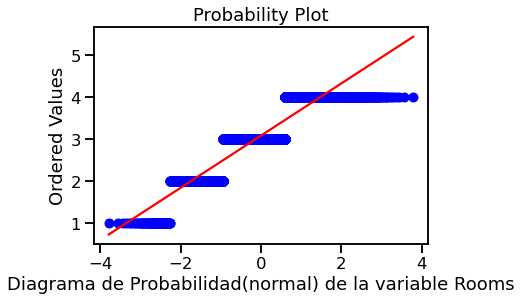

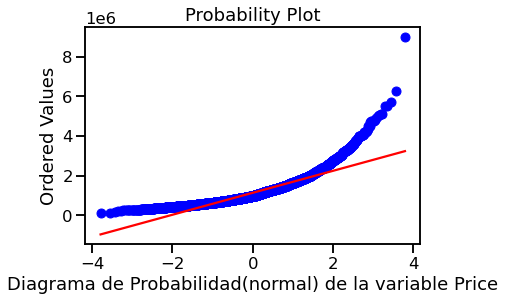

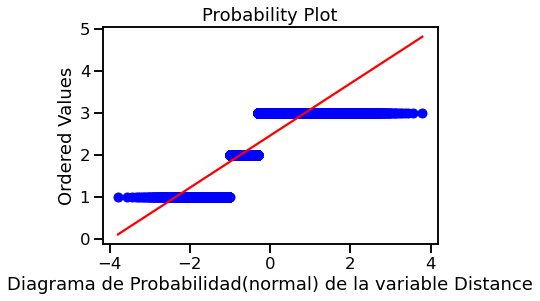

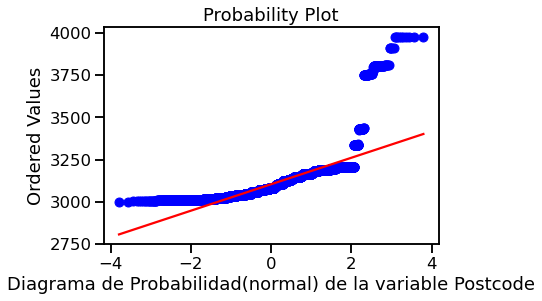

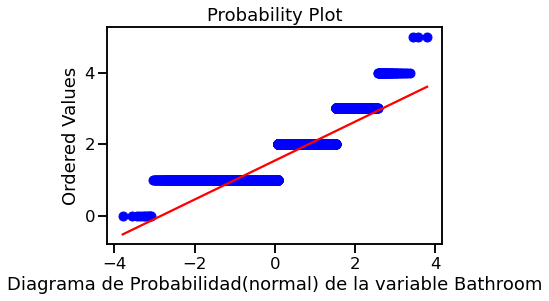

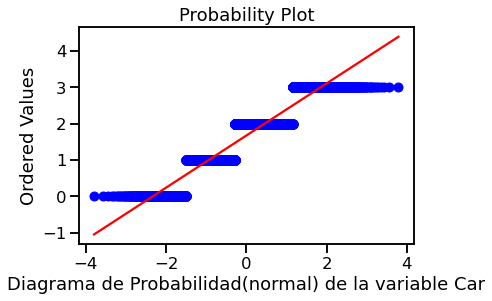

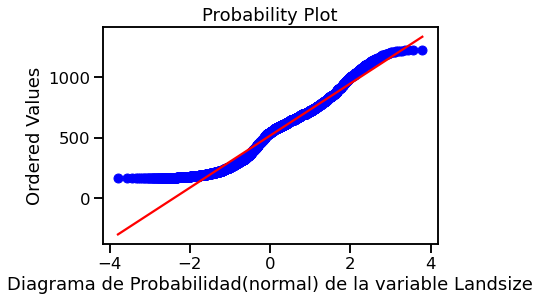

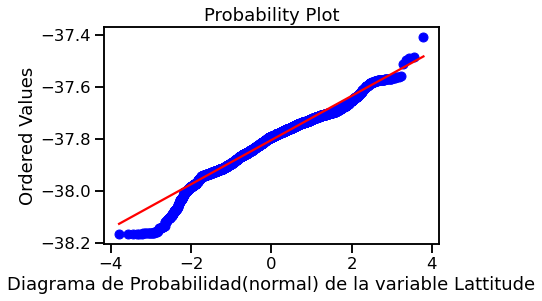

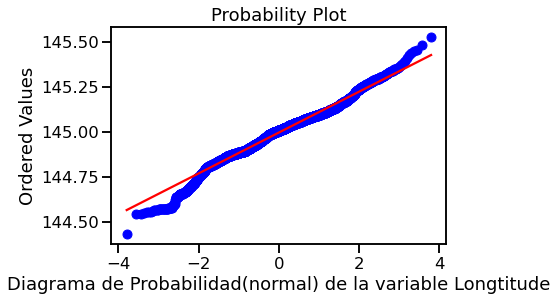

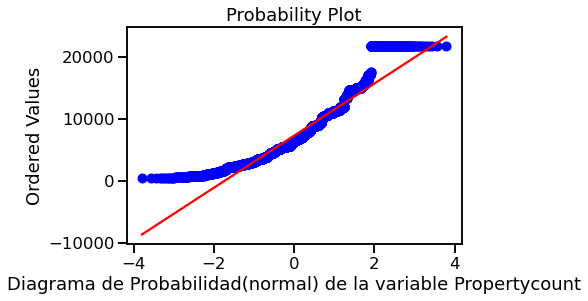

In [73]:
def normalidad_variable_numerica(col):
    stats.probplot(melb_df[col], plot=plot)
    plot.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plot.show()
    
#cols = melb_df[['Price','Rooms','Distance','Postcode','Bathroom','Car','Landsize']].columns
cols = melb_df.select_dtypes(['int', 'float']).columns

for col in cols:
    normalidad_variable_numerica(col)

### Histogramas
Podemos crear un histograma para ver la distribución de las variables.

In [74]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname',
       'Propertycount'],
      dtype='object')

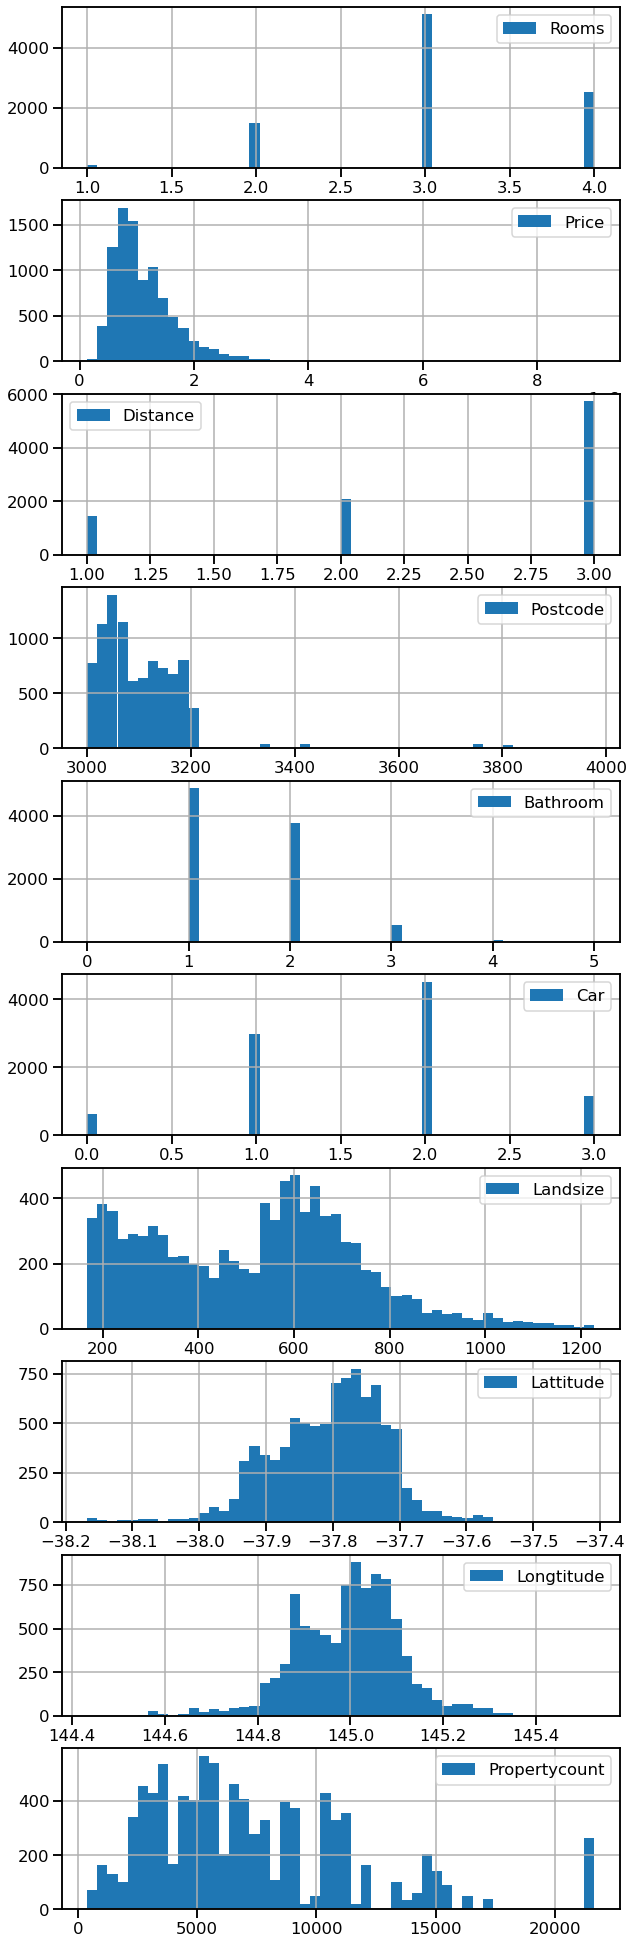

In [75]:
fig, axs = plot.subplots(len(cols), figsize=(10, 35))
for n, col in enumerate(cols):
    melb_df[col].hist(ax=axs[n],bins=50, label=col)
    axs[n].legend()

Con estos graficos podemos determinar que las variables price, distance, latitude y longitud tienden a una distribucion aproximadamente normal.

In [76]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname',
       'Propertycount'],
      dtype='object')

In [77]:
selected_columns = ['Suburb','Rooms','Type','Price','Postcode','Distance','Bathroom','Car','Landsize','CouncilArea']
melb_df = melb_df[selected_columns]
melb_df

,Suburb,Rooms,Type,Price,Postcode,Distance,Bathroom,Car,Landsize,CouncilArea
0,Abbotsford,2,h,1480000.0,3067.0,1.0,1.0,1.0,202.0,Yarra
5,Abbotsford,2,h,941000.0,3067.0,1.0,1.0,0.0,181.0,Yarra
6,Abbotsford,3,h,1876000.0,3067.0,1.0,2.0,0.0,245.0,Yarra
7,Abbotsford,2,h,1636000.0,3067.0,1.0,1.0,2.0,256.0,Yarra
9,Abbotsford,2,h,1097000.0,3067.0,1.0,1.0,2.0,220.0,Yarra
...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,4,h,1245000.0,3150.0,3.0,2.0,2.0,652.0,Monash
13576,Williamstown,3,h,1031000.0,3016.0,2.0,2.0,2.0,333.0,Hobsons Bay
13577,Williamstown,3,h,1170000.0,3016.0,2.0,2.0,3.0,436.0,Hobsons Bay
13578,Williamstown,4,h,2500000.0,3016.0,2.0,1.0,3.0,866.0,Hobsons Bay


### Columnas no seleccionadas

- Address, Method, SeleerG, Date, Bedroom2, BuildingArea, YearBuilt, Lattitude, Longitude, Regionname y Propertycount: se descartan porque no aportan informacion relevante o aportan informacion duplicada que se puede inferir de otra variable.

---

## AIRBNB_DF

In [78]:
airbnb_df.head()

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071,-37.758971,144.989228,50,250.0,920.0
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183,-37.864530,144.992238,69,400.0,1900.0


In [79]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

### Feature description

In [80]:
describe(airbnb_df,'description')

Hay 22563 elementos.
Hay 21678 elementos únicos.
El elemento mas frecuente es nan y ocurre 332 veces.
Hay 332 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature neighborhood_overview

In [81]:
describe(airbnb_df,'neighborhood_overview')

Hay 14424 elementos.
Hay 12042 elementos únicos.
El elemento mas frecuente es nan y ocurre 8471 veces.
Hay 8471 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature street

In [82]:
describe(airbnb_df,'street')

Hay 22895 elementos.
Hay 637 elementos únicos.
El elemento mas frecuente es Melbourne, VIC, Australia y ocurre 4222 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature neighborhood

In [83]:
describe(airbnb_df,'neighborhood')

Hay 17082 elementos.
Hay 60 elementos únicos.
El elemento mas frecuente es nan y ocurre 5813 veces.
Hay 5813 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature city

In [84]:
describe(airbnb_df,'city')

Hay 22895 elementos.
Hay 30 elementos únicos.
El elemento mas frecuente es Melbourne y ocurre 7368 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature suburb

Hay 22872 elementos.
Hay 543 elementos únicos.
El elemento mas frecuente es Melbourne y ocurre 4274 veces.
Hay 23 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='suburb'>

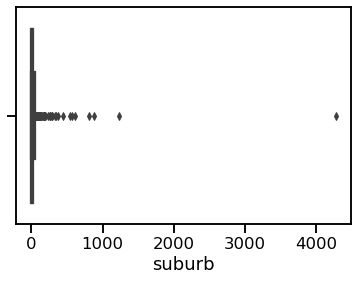

In [85]:
describe(airbnb_df,'suburb')
vc = airbnb_df.suburb.value_counts()
seaborn.boxplot(x=vc)

Después de remover outlier con IQR mantenemos un porcentaje del 2.06 % sobre el dataset original
Hay 471 elementos.
Hay 47 elementos únicos.
El elemento mas frecuente es 1 y ocurre 139 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


<AxesSubplot:xlabel='suburb'>

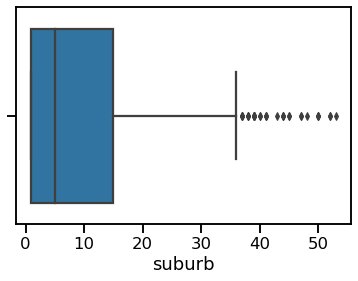

In [86]:
iqr_factor = 1.5
suburb = airbnb_df.copy()
suburb_main_inliers, suburb_main_outliers = remove_outlier(pandas.DataFrame(airbnb_df.suburb.value_counts()), "suburb", iqr_factor)
p = (len(suburb_main_inliers) / len(suburb)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(suburb_main_inliers,'suburb')
seaborn.boxplot(data=suburb_main_inliers, x='suburb')

### Feature state

In [87]:
describe(airbnb_df,'state')

Hay 22834 elementos.
Hay 28 elementos únicos.
El elemento mas frecuente es VIC y ocurre 21858 veces.
Hay 61 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature zipcode

In [88]:
describe(airbnb_df,'zipcode')

Hay 22753 elementos.
Hay 252 elementos únicos.
El elemento mas frecuente es 3000 y ocurre 3367 veces.
Hay 142 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


In [89]:
airbnb_df['zipcode'] = pandas.to_numeric(airbnb_df.zipcode, errors='coerce')

In [90]:
intersection = numpy.intersect1d(airbnb_df.zipcode.values, melb_df.Postcode.values, assume_unique=False)
print("Airbnb unique zipcodes", len(airbnb_df.zipcode.unique()))
print("Sales unique zipcodes", len(melb_df.Postcode.unique()))
print("Common zipcodes", len(intersection))
print('Records in Sales df with corresponding zipcode form Sales df',
      melb_df.Postcode.isin(intersection).sum() / len(melb_df))
print('Records in Airbnb df with corresponding zipcode form Airbnb df',
      airbnb_df.zipcode.isin(intersection).sum() / len(airbnb_df))

Airbnb unique zipcodes 248
Sales unique zipcodes 192
Common zipcodes 187
Records in Sales df with corresponding zipcode form Sales df 0.998701579744644
Records in Airbnb df with corresponding zipcode form Airbnb df 0.9026424983620878


In [91]:
#utilizo la funcion count y mean a price para agregarlo como variables
priceByZipCode = airbnb_df[['price','zipcode']].groupby('zipcode')\
   .agg(airbnb_record_count=('price', 'count'),
    airbnb_price_day_mean=('price', 'mean'))\
   .reset_index()
priceByZipCode.head()

,zipcode,airbnb_record_count,airbnb_price_day_mean
0,2010.0,1,40.000000
1,2134.0,1,50.000000
2,2582.0,1,104.000000
3,3000.0,3367,150.504307
4,3001.0,2,132.500000


### Feature latitude y longitude

In [92]:
describe(airbnb_df,'latitude')
print("\n")
describe(airbnb_df,'longitude')

Hay 22895 elementos.
Hay 22874 elementos únicos.
El elemento mas frecuente es -37.801278 y ocurre 2 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


Hay 22895 elementos.
Hay 22700 elementos únicos.
El elemento mas frecuente es 144.9802035 y ocurre 3 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature price

Hay 22895 elementos.
Hay 458 elementos únicos.
El elemento mas frecuente es 100 y ocurre 1209 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 21 elementos con ceros.


<AxesSubplot:xlabel='price'>

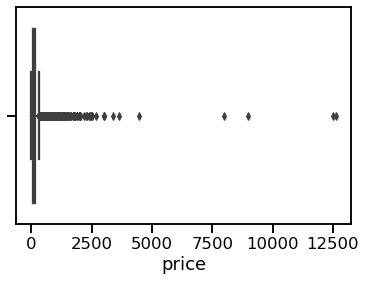

In [93]:
describe(airbnb_df,'price')
seaborn.boxplot(data=airbnb_df, x='price')

Después de remover outlier con IQR mantenemos un porcentaje del 93.68 % sobre el dataset original
Hay 21448 elementos.
Hay 210 elementos únicos.
El elemento mas frecuente es 100 y ocurre 1209 veces.
Hay 0 elementos nulos.
Hay 0 elementos vacíos.
Hay 21 elementos con ceros.


<AxesSubplot:xlabel='price'>

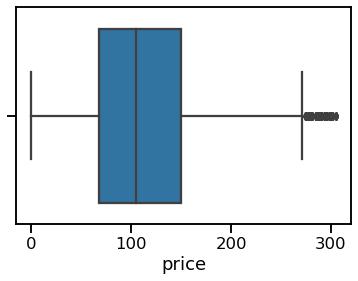

In [94]:
iqr_factor = 1.5
price = airbnb_df.copy()
price_main_inliers, price_main_outliers = remove_outlier(price, "price", iqr_factor)
p = (len(price_main_inliers) / len(price)) * 100
print(f'Después de remover outlier con IQR mantenemos un porcentaje del {round(p,2)} % sobre el dataset original')
describe(price_main_inliers,'price')
seaborn.boxplot(data=price_main_inliers, x='price')

In [95]:
airbnb_df = price_main_inliers.copy()

### Feature weekly_price

In [96]:
describe(airbnb_df,'weekly_price')

Hay 2365 elementos.
Hay 530 elementos únicos.
El elemento mas frecuente es 700.0 y ocurre 74 veces.
Hay 19083 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


### Feature monthly_price

In [97]:
describe(airbnb_df,'monthly_price')

Hay 1782 elementos.
Hay 572 elementos únicos.
El elemento mas frecuente es 2000.0 y ocurre 51 veces.
Hay 19666 elementos nulos.
Hay 0 elementos vacíos.
Hay 0 elementos con ceros.


Antes de unir los conjuntos de datos, tenemos que asegurarnos de que tengamos suficientes registros en común como para agregar información relevantes.

### Análisis valores faltantes

<AxesSubplot:>

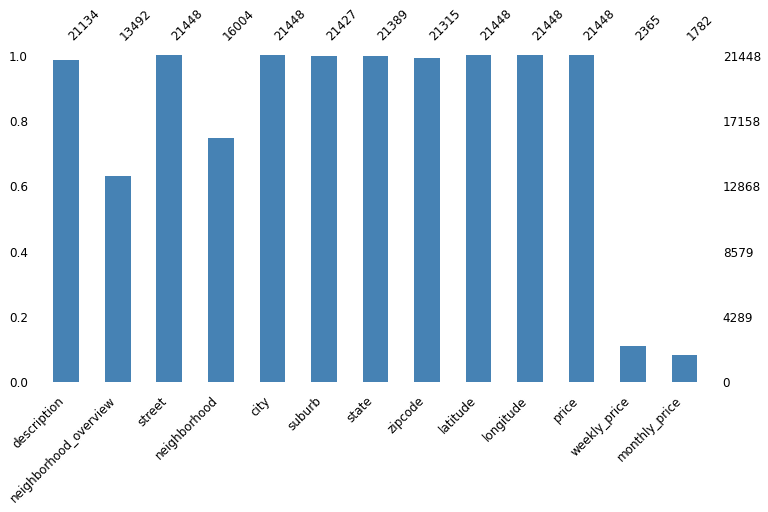

In [98]:
msno.bar(airbnb_df,figsize=(12, 6), fontsize=12, color='steelblue')

<AxesSubplot:>

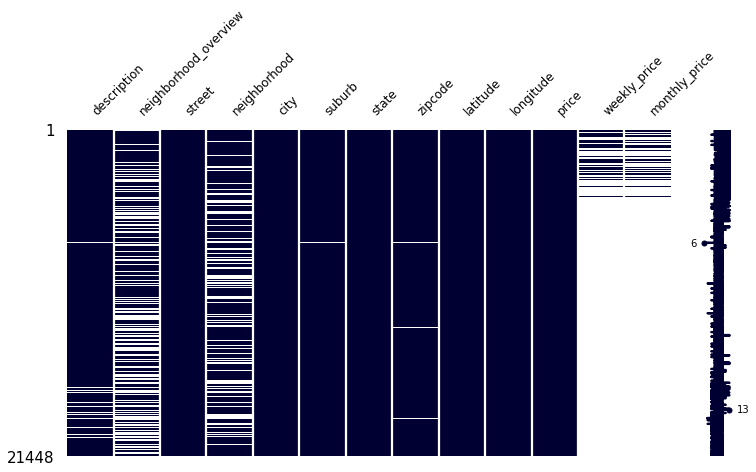

In [99]:
msno.matrix(airbnb_df,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

## Análisis AIRBNB VS MELB_DF

In [100]:
#genero un array de los valores en formato str
array=melb_df.Suburb.values
array_str_df=[]
for i in array:
    array_str_df.append(str(i))
array2=airbnb_df.suburb.values
array_str_airbnb=[]
for i in array2:
    array_str_airbnb.append(str(i))
    
#realizo la interseccion de arrays en formato str
def flatten(x):
    result = []
    for el in x:
        if isinstance(x, collections.Iterable) and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result
 
a = flatten(array_str_airbnb)
b = flatten(array_str_df)
common_elements = list(set(a).intersection(set(b)))


print("Airbnb unique suburb", len(airbnb_df.suburb.unique()))
print("Sales unique suburb", len(melb_df.Suburb.unique()))
print("Common suburb", len(common_elements))

Airbnb unique suburb 532
Sales unique suburb 306
Common suburb 291


<ipython-input-100-ed6fe28e5176>:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(x, collections.Iterable) and not isinstance(el, str):


Podemos observar que la mayoría coinciden

In [101]:
#genero un array de los valores en formato str
array=melb_df.Suburb.values
array_str_df=[]
for i in array:
    array_str_df.append(str(i))
array2=airbnb_df.neighborhood.values
array_str_airbnb=[]
for i in array2:
    array_str_airbnb.append(str(i))
    
#realizo la interseccion de arrays en formato str
import collections
def flatten(x):
    result = []
    for el in x:
        if isinstance(x, collections.Iterable) and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result
 
a = flatten(array_str_airbnb)
b = flatten(array_str_df)
common_elements = list(set(a).intersection(set(b)))


print("Airbnb unique neighborhood", len(airbnb_df.neighborhood.unique()))
print("Sales unique suburb", len(melb_df.Suburb.unique()))
print("Common suburb", len(common_elements))
#se ve que la mayoria de los valores de sales estan en el de airbnb

Airbnb unique neighborhood 60
Sales unique suburb 306
Common suburb 50


Analizamos las dos variables que se podrian utilizar para realizar la union, de las cuales observamos que las variables suburb y neighborhood del dataframe airbnb podria utilizarse para realizar el merge con la variable suburb de melb_df. 
Podriamos utilizar un join para unir los valores de neighboorhood con suburb para que incluya todos los valores de suburb y no solo los comunes.

## MERGE

In [102]:
merged_df = melb_df[selected_columns].merge(
    priceByZipCode, how='left',
    left_on='Postcode', right_on='zipcode'
)
merged_df

,Suburb,Rooms,Type,Price,Postcode,Distance,Bathroom,Car,Landsize,CouncilArea,zipcode,airbnb_record_count,airbnb_price_day_mean
0,Abbotsford,2,h,1480000.0,3067.0,1.0,1.0,1.0,202.0,Yarra,3067.0,258.0,130.624031
1,Abbotsford,2,h,941000.0,3067.0,1.0,1.0,0.0,181.0,Yarra,3067.0,258.0,130.624031
2,Abbotsford,3,h,1876000.0,3067.0,1.0,2.0,0.0,245.0,Yarra,3067.0,258.0,130.624031
3,Abbotsford,2,h,1636000.0,3067.0,1.0,1.0,2.0,256.0,Yarra,3067.0,258.0,130.624031
4,Abbotsford,2,h,1097000.0,3067.0,1.0,1.0,2.0,220.0,Yarra,3067.0,258.0,130.624031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,Wheelers Hill,4,h,1245000.0,3150.0,3.0,2.0,2.0,652.0,Monash,3150.0,189.0,124.026455
9238,Williamstown,3,h,1031000.0,3016.0,2.0,2.0,2.0,333.0,Hobsons Bay,3016.0,74.0,191.094595
9239,Williamstown,3,h,1170000.0,3016.0,2.0,2.0,3.0,436.0,Hobsons Bay,3016.0,74.0,191.094595
9240,Williamstown,4,h,2500000.0,3016.0,2.0,1.0,3.0,866.0,Hobsons Bay,3016.0,74.0,191.094595


# Ejercicio 2: Imputación

1. Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).

2. Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.



In [103]:
missing_values_count = merged_df['CouncilArea'].isna().sum() 
print(f"Existen {missing_values_count} filas con valores nulos en CouncilArea")

Existen 3 filas con valores nulos en CouncilArea


In [104]:
merged_df

,Suburb,Rooms,Type,Price,Postcode,Distance,Bathroom,Car,Landsize,CouncilArea,zipcode,airbnb_record_count,airbnb_price_day_mean
0,Abbotsford,2,h,1480000.0,3067.0,1.0,1.0,1.0,202.0,Yarra,3067.0,258.0,130.624031
1,Abbotsford,2,h,941000.0,3067.0,1.0,1.0,0.0,181.0,Yarra,3067.0,258.0,130.624031
2,Abbotsford,3,h,1876000.0,3067.0,1.0,2.0,0.0,245.0,Yarra,3067.0,258.0,130.624031
3,Abbotsford,2,h,1636000.0,3067.0,1.0,1.0,2.0,256.0,Yarra,3067.0,258.0,130.624031
4,Abbotsford,2,h,1097000.0,3067.0,1.0,1.0,2.0,220.0,Yarra,3067.0,258.0,130.624031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,Wheelers Hill,4,h,1245000.0,3150.0,3.0,2.0,2.0,652.0,Monash,3150.0,189.0,124.026455
9238,Williamstown,3,h,1031000.0,3016.0,2.0,2.0,2.0,333.0,Hobsons Bay,3016.0,74.0,191.094595
9239,Williamstown,3,h,1170000.0,3016.0,2.0,2.0,3.0,436.0,Hobsons Bay,3016.0,74.0,191.094595
9240,Williamstown,4,h,2500000.0,3016.0,2.0,1.0,3.0,866.0,Hobsons Bay,3016.0,74.0,191.094595


In [105]:
merged_df.isna().any()
#observamos los valores true en las variables que tienen valores nulos.

Suburb                   False
Rooms                    False
Type                     False
Price                    False
Postcode                 False
Distance                 False
Bathroom                 False
Car                      False
Landsize                 False
CouncilArea               True
zipcode                   True
airbnb_record_count       True
airbnb_price_day_mean     True
dtype: bool

In [106]:
# Get CouncilArea & Suburb dummies
dummies_variables = merged_df[['CouncilArea','Suburb']]
df_dummies = pandas.get_dummies(dummies_variables,dummy_na=True)

#borro las columnas generadas con nan. Se pone en las columnas correspondientes un nan y no un 0.
nan_df = df_dummies.loc[:, df_dummies.columns.str.endswith("_nan")]
pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_dummies.index:
    for col_nan in nan_df.columns:
        if df_dummies.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_dummies.columns[df_dummies.columns.str.startswith(col_id+'_')]
            df_dummies.loc[index, targets] = numpy.nan
            
df_dummies.drop(df_dummies.columns[df_dummies.columns.str.endswith('_nan')], axis=1, inplace=True)

# Inputing by suburb
imputer = KNNImputer(n_neighbors=5)
df_dummies = pandas.DataFrame(imputer.fit_transform(df_dummies),columns = df_dummies.columns)

# Concat new dummies vars and drop unused columns
df = pandas.concat([merged_df,df_dummies],axis=1)
df=df.drop(["CouncilArea"],axis=1)
df=df.drop(["Suburb"],axis=1)

In [107]:
# Get dummies for Type
new_dummies_variables = df[['Type']]
new_df_dummies = pandas.get_dummies(new_dummies_variables)

## Concat type dummies
new_df = pandas.concat([df,new_df_dummies],axis=1)
new_df = new_df.drop(['Type'],axis=1)

# Scalling
scaler = MinMaxScaler()
new_df = pandas.DataFrame(scaler.fit_transform(new_df), columns = new_df.columns)

# Inputing rest of the missing values
imputer = KNNImputer(n_neighbors=5)
new_df = pandas.DataFrame(imputer.fit_transform(new_df),columns = new_df.columns)
new_df

,Rooms,Price,Postcode,Distance,Bathroom,Car,Landsize,zipcode,airbnb_record_count,airbnb_price_day_mean,...,Suburb_Williamstown North,Suburb_Windsor,Suburb_Wollert,Suburb_Wyndham Vale,Suburb_Yallambie,Suburb_Yarra Glen,Suburb_Yarraville,Type_h,Type_t,Type_u
0,0.333333,0.152103,0.068577,0.0,0.2,0.333333,0.032988,0.068577,0.076352,0.126027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.333333,0.091329,0.068577,0.0,0.2,0.000000,0.013195,0.068577,0.076352,0.126027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.666667,0.196753,0.068577,0.0,0.4,0.000000,0.073516,0.068577,0.076352,0.126027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.333333,0.169692,0.068577,0.0,0.2,0.666667,0.083883,0.068577,0.076352,0.126027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.333333,0.108919,0.068577,0.0,0.2,0.666667,0.049953,0.068577,0.076352,0.126027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,1.000000,0.125606,0.153531,1.0,0.4,0.666667,0.457116,0.153531,0.055853,0.116852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9238,0.666667,0.101477,0.016377,0.5,0.4,0.666667,0.156456,0.016377,0.021687,0.210121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9239,0.666667,0.117150,0.016377,0.5,0.4,1.000000,0.253534,0.016377,0.021687,0.210121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9240,1.000000,0.267110,0.016377,0.5,0.2,1.000000,0.658812,0.016377,0.021687,0.210121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [108]:
print(f"Hay {new_df.isna().any().head(60).sum()} valores con nulos")
#No hay mas valores nulos en el df

Hay 0 valores con nulos


Se elimina los dummies que comienzan con "suburb" ya que fueron utilizadas en la imputación de CouncilArea utilizando esta variable como variable de región.

También sacamos zipcode y postcode debido a que fueron utilizados para la realización del merge y no lo utilizaremos para predecir el precio.

In [109]:
new_df.drop(new_df.columns[new_df.columns.str.startswith('Suburb_')], axis=1, inplace=True)

In [110]:
new_df.drop(['zipcode','Postcode'] ,axis=1, inplace=True)

In [111]:
new_df

,Rooms,Price,Distance,Bathroom,Car,Landsize,airbnb_record_count,airbnb_price_day_mean,CouncilArea_Banyule,CouncilArea_Bayside,...,CouncilArea_Port Phillip,CouncilArea_Stonnington,CouncilArea_Whitehorse,CouncilArea_Whittlesea,CouncilArea_Wyndham,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Type_h,Type_t,Type_u
0,0.333333,0.152103,0.0,0.2,0.333333,0.032988,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.333333,0.091329,0.0,0.2,0.000000,0.013195,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.666667,0.196753,0.0,0.4,0.000000,0.073516,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.333333,0.169692,0.0,0.2,0.666667,0.083883,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.333333,0.108919,0.0,0.2,0.666667,0.049953,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,1.000000,0.125606,1.0,0.4,0.666667,0.457116,0.055853,0.116852,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9238,0.666667,0.101477,0.5,0.4,0.666667,0.156456,0.021687,0.210121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9239,0.666667,0.117150,0.5,0.4,1.000000,0.253534,0.021687,0.210121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9240,1.000000,0.267110,0.5,0.2,1.000000,0.658812,0.021687,0.210121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [112]:
new_df.to_csv('Dataframe_melb_B.csv',index=False)

In [113]:
new_df=pandas.read_csv("Dataframe_melb_B.csv")
new_df

,Rooms,Price,Distance,Bathroom,Car,Landsize,airbnb_record_count,airbnb_price_day_mean,CouncilArea_Banyule,CouncilArea_Bayside,...,CouncilArea_Port Phillip,CouncilArea_Stonnington,CouncilArea_Whitehorse,CouncilArea_Whittlesea,CouncilArea_Wyndham,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Type_h,Type_t,Type_u
0,0.333333,0.152103,0.0,0.2,0.333333,0.032988,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.333333,0.091329,0.0,0.2,0.000000,0.013195,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.666667,0.196753,0.0,0.4,0.000000,0.073516,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.333333,0.169692,0.0,0.2,0.666667,0.083883,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.333333,0.108919,0.0,0.2,0.666667,0.049953,0.076352,0.126027,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,1.000000,0.125606,1.0,0.4,0.666667,0.457116,0.055853,0.116852,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9238,0.666667,0.101477,0.5,0.4,0.666667,0.156456,0.021687,0.210121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9239,0.666667,0.117150,0.5,0.4,1.000000,0.253534,0.021687,0.210121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9240,1.000000,0.267110,0.5,0.2,1.000000,0.658812,0.021687,0.210121,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
